In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
import gc
import tensorflow as tf
import wtte.wtte as wtte
from keras.models import Sequential, load_model,Model
from keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from keras import backend as K
from keras import callbacks
from keras.optimizers import RMSprop,adam,Nadam
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
import os
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# path = '../Tax_paper/code/output_files/results/'
# a = os.path.join(path,'suffix_and_remaining_time_helpdesk.csv')
# b = os.path.join(path,'suffix_and_remaining_time_bpi_12_w.csv')
# c = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
# d = os.path.join(path,'suffix_and_remaining_time_env_permit.csv')

path = '../Tax_paper/data/'
a = os.path.join(path,'helpdesk.csv')
b = os.path.join(path,'bpi_12_w.csv')
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
d = os.path.join(path,'env_permit.csv')

a = pd.read_csv(a)
b = pd.read_csv(b)
c = pd.read_csv(c)
d = pd.read_csv(d)

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

# for key, dataset in df_dict.items():
#     plt.figure(figsize=(10,5))
#     sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
#     plt.title(key,fontsize=18)
#     plt.plot()

In [10]:
# baseline = {}
# for dataset in ['a','b','c','d']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

In [ ]:
filename = "NoTrail_T2E"
maes = {}
results = {}
for key,dataset in df_dict.items():
    mae_list=[]
    print("\ndataset:",key)
    for suffix in range_dict[key]:
        print("\t\tsuffix:",suffix)
        print("\t\t\tsuffix splitting", end = " ... ")
        print("\n\t\t\tpreprocessing", end =" ... ")
        dataset_preprocessed = preprocess(dataset,suffix+1)
        X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                     train_perc = 0.67,
                                                                     val_perc = 0.20,
                                                                     suffix = suffix,
                                                                     scaling = False)
        X_train, y_train = balance_labels(X_train, y_train)
        X_val, y_val = balance_labels(X_val, y_val)
        print("done")
        print('\t\t\t',len(X_train),len(X_val), len(X_test))
        print("\t\t\tTraining", end =" ........... ")
        model = train(X_train, y_train, X_val, y_val)
        model.load_weights('best_model.h5')
        print("done")
        result_df, mae = evaluating(X_test,y_test,model)
        mae_list.append(mae)
        print("\t\t\tMAE: ",mae_list[-1])
        results[key+str(suffix)] = result_df['predicted_mode']
    maes[key] = mae_list
pickle.dump(maes, open(filename+".pkl","wb"))
pickle.dump(results, open(filename+"_pred.pkl","wb"))


dataset: a
		suffix: 2
			suffix splitting ... 	preprocessing ... done
			 615 148 449
			Training ........... done
			MAE:  10.189828846305375
		suffix: 3
			suffix splitting ... 	preprocessing ... done
			 287 72 207
			Training ........... done
			MAE:  10.911612453329678
		suffix: 4
			suffix splitting ... 	preprocessing ... 

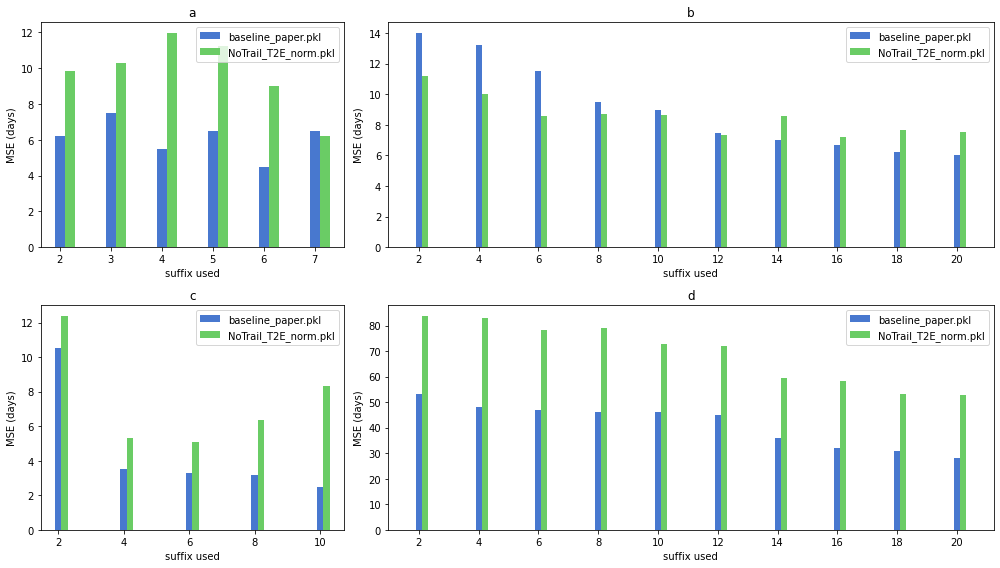

In [12]:
cases = ["baseline_paper.pkl","NoTrail_T2E_norm.pkl"]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(14,8))

for i,dataset in enumerate(['a','b','c','d']):
    if dataset == 'a':
        plt.sca(ax[0][0])
    elif dataset == 'b':
        plt.sca(ax[0][1])
    elif dataset == 'c':
        plt.sca(ax[1][0])
    elif dataset == 'd':
        plt.sca(ax[1][1])

    X = np.array(range_dict[dataset])
    steps = [ 0, 0.2]
    for j,case in enumerate(cases):
        data = list(pickle.load(open(case,"rb")).values())[i];
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

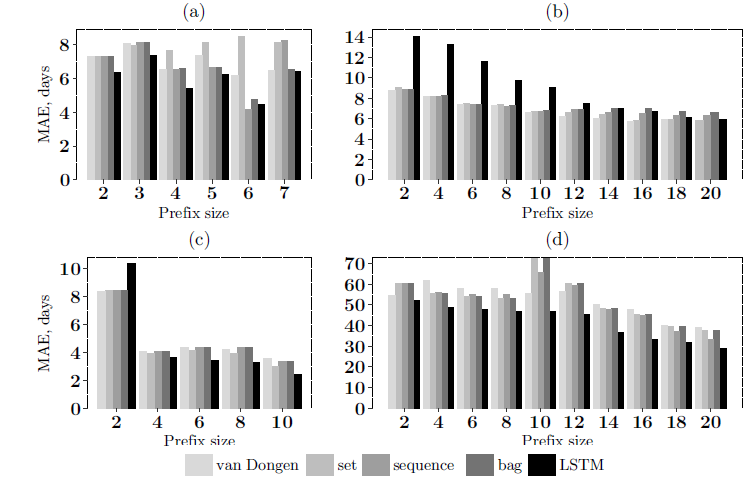

###############################################################################################################################

In [1]:
## Testing

In [93]:
suffix = 4
dataset = df_dict['a']
dataset_preprocessed = preprocess(dataset, suffix+1)

X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed,0.67,0.2,suffix,scaling=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2973, 4, 11), (2973, 2), (743, 4, 11), (743, 2), (87, 4, 11), (87, 2))

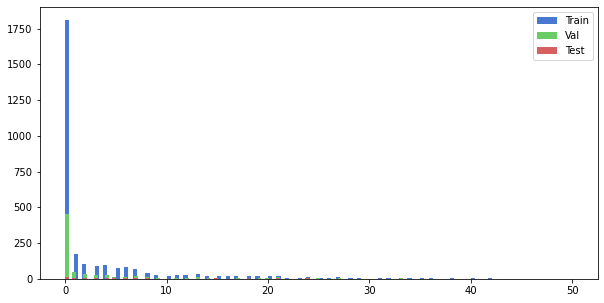

In [94]:
plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = 120,label="Train");
plt.hist(y_val[:,0], bins = 120,label="Val");
plt.hist(y_test[:,0], bins = 120, label="Test");
plt.legend()
plt.show()

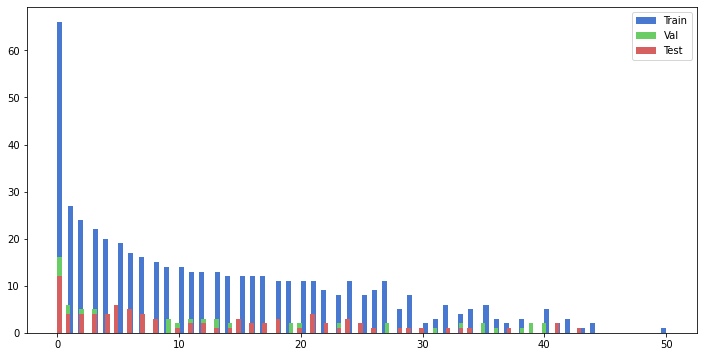

In [96]:
plt.figure(figsize=(12,6))
plt.hist(y_train[:,0], bins = 120,label="Train");
plt.hist(y_val[:,0], bins = 120,label="Val");
plt.hist(y_test[:,0], bins = 120, label="Test");
plt.legend()
plt.show()

In [187]:
# dataset_preprocessed.loc[(dataset_preprocessed["fvt1"] > 16.390277) & (dataset_preprocessed["fvt1"] < 16.390279) ]
# dataset_preprocessed.loc[dataset_preprocessed["CaseID"] == 368]

## Model

In [97]:
from keras.callbacks import CSVLogger

def train_notebook(X_train, y_train, X_val, y_val):
    tte_mean_train = np.nanmean(y_train[:,0].astype('float'))
    mean_u = np.nanmean(y_train[:,1].astype('float'))
    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    history = History()
    csv_logger = CSVLogger('training.log', separator=',', append=False)
    n_features = X_train.shape[-1]
    
    main_input = Input(shape=(None, n_features), name='main_input')
#     mask_input = Masking(mask_value=-100, name='mask_input')(main_input)

    l1 = GRU(4, activation='tanh', recurrent_dropout=0.25,return_sequences=False)(main_input)
#     l11 = GRU(10, activation='tanh', recurrent_dropout=0.25,return_sequences=False)(l1)
    b1 = BatchNormalization()(l1)
    l2 = Dense(2, name='Dense')(b1)
    b2 = BatchNormalization()(l2)
    output = Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha,"max_beta_value":100, "scalefactor":0.5})(b2)
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    loss = wtte.loss(kind='continuous',reduce_loss=False).loss_function
    model = Model(inputs=[main_input], outputs=[output])
    model.compile(loss=loss, optimizer=adam(lr=0.01))
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=150, restore_best_weights=True)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=True, save_best_only=True, save_weights_only=True)
    mg_train = batch_gen(X_train, y_train)
    mg_val = batch_gen(X_val, y_val)
    model.fit_generator(mg_train, 
                    epochs=500,
                    steps_per_epoch = ceil(len(X_train) / batch_size),
                    validation_data=(mg_val),
                    validation_steps= ceil(len(X_val) / batch_size),
                    verbose=True,
                    callbacks=[history,es,mc,csv_logger]
                   )
    return model
model = train_notebook(X_train, y_train, X_val, y_val)

Epoch 1/500
4/4 [==============================] - 2s 418ms/step - loss: 3.2565 - val_loss: 3.3560

Epoch 00001: val_loss improved from inf to 3.35595, saving model to best_model.h5
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 3.0969 - val_loss: 3.3471

Epoch 00002: val_loss improved from 3.35595 to 3.34710, saving model to best_model.h5
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 3.0525 - val_loss: 3.3418

Epoch 00003: val_loss improved from 3.34710 to 3.34178, saving model to best_model.h5
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 3.0399 - val_loss: 3.3347

Epoch 00004: val_loss improved from 3.34178 to 3.33474, saving model to best_model.h5
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 2.9933 - val_loss: 3.3287

Epoch 00005: val_loss improved from 3.33474 to 3.32869, saving model to best_model.h5
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 2.9476 - 

Epoch 47/500
4/4 [==============================] - 0s 7ms/step - loss: 2.5319 - val_loss: 2.9801

Epoch 00047: val_loss improved from 3.00168 to 2.98009, saving model to best_model.h5
Epoch 48/500
4/4 [==============================] - 0s 8ms/step - loss: 2.5345 - val_loss: 2.9647

Epoch 00048: val_loss improved from 2.98009 to 2.96475, saving model to best_model.h5
Epoch 49/500
4/4 [==============================] - 0s 8ms/step - loss: 2.5386 - val_loss: 2.9534

Epoch 00049: val_loss improved from 2.96475 to 2.95339, saving model to best_model.h5
Epoch 50/500
4/4 [==============================] - 0s 10ms/step - loss: 2.5197 - val_loss: 2.9423

Epoch 00050: val_loss improved from 2.95339 to 2.94234, saving model to best_model.h5
Epoch 51/500
4/4 [==============================] - 0s 8ms/step - loss: 2.5077 - val_loss: 2.9413

Epoch 00051: val_loss improved from 2.94234 to 2.94132, saving model to best_model.h5
Epoch 52/500
4/4 [==============================] - 0s 9ms/step - loss: 2.

Epoch 99/500
4/4 [==============================] - 0s 9ms/step - loss: 2.4695 - val_loss: 2.8977

Epoch 00099: val_loss did not improve from 2.89240
Epoch 100/500
4/4 [==============================] - 0s 9ms/step - loss: 2.4214 - val_loss: 2.9151

Epoch 00100: val_loss did not improve from 2.89240
Epoch 101/500
4/4 [==============================] - 0s 10ms/step - loss: 2.4289 - val_loss: 2.9116

Epoch 00101: val_loss did not improve from 2.89240
Epoch 102/500
4/4 [==============================] - 0s 10ms/step - loss: 2.4565 - val_loss: 2.9104

Epoch 00102: val_loss did not improve from 2.89240
Epoch 103/500
4/4 [==============================] - 0s 11ms/step - loss: 2.4646 - val_loss: 2.9227

Epoch 00103: val_loss did not improve from 2.89240
Epoch 104/500
4/4 [==============================] - 0s 9ms/step - loss: 2.4327 - val_loss: 2.9352

Epoch 00104: val_loss did not improve from 2.89240
Epoch 105/500
4/4 [==============================] - 0s 8ms/step - loss: 2.4346 - val_loss: 

4/4 [==============================] - 0s 7ms/step - loss: 2.3494 - val_loss: 3.0349

Epoch 00153: val_loss did not improve from 2.88753
Epoch 154/500
4/4 [==============================] - 0s 8ms/step - loss: 2.3856 - val_loss: 3.0346

Epoch 00154: val_loss did not improve from 2.88753
Epoch 155/500
4/4 [==============================] - 0s 7ms/step - loss: 2.3776 - val_loss: 3.0154

Epoch 00155: val_loss did not improve from 2.88753
Epoch 156/500
4/4 [==============================] - 0s 8ms/step - loss: 2.4145 - val_loss: 3.0065

Epoch 00156: val_loss did not improve from 2.88753
Epoch 157/500
4/4 [==============================] - 0s 8ms/step - loss: 2.3706 - val_loss: 3.0267

Epoch 00157: val_loss did not improve from 2.88753
Epoch 158/500
4/4 [==============================] - 0s 8ms/step - loss: 2.3590 - val_loss: 3.0510

Epoch 00158: val_loss did not improve from 2.88753
Epoch 159/500
4/4 [==============================] - 0s 9ms/step - loss: 2.3753 - val_loss: 3.0493

Epoch 00

4/4 [==============================] - 0s 8ms/step - loss: 2.3376 - val_loss: 3.0971

Epoch 00261: val_loss did not improve from 2.88753
Epoch 262/500
4/4 [==============================] - 0s 9ms/step - loss: 2.3047 - val_loss: 3.1257

Epoch 00262: val_loss did not improve from 2.88753
Epoch 263/500
4/4 [==============================] - 0s 9ms/step - loss: 2.3782 - val_loss: 3.1459

Epoch 00263: val_loss did not improve from 2.88753
Epoch 264/500
4/4 [==============================] - 0s 10ms/step - loss: 2.3212 - val_loss: 3.1580

Epoch 00264: val_loss did not improve from 2.88753
Epoch 265/500
4/4 [==============================] - 0s 7ms/step - loss: 2.3896 - val_loss: 3.1657

Epoch 00265: val_loss did not improve from 2.88753
Epoch 266/500
4/4 [==============================] - 0s 8ms/step - loss: 2.3435 - val_loss: 3.1623
Restoring model weights from the end of the best epoch

Epoch 00266: val_loss did not improve from 2.88753
Epoch 00266: early stopping


10.896237948438259


,T,U,alpha,beta,predicted_mode,error,abs_error,Accurate
0,0,1,13.0827,0.898281,0.000000,0,0,True
1,41,1,18.9075,1.77776,11.876203,29.1238,29.1238,False
2,26,1,22.5665,1.47531,10.472234,15.5278,15.5278,False
3,21,1,28.3447,2.37185,22.502015,-1.50202,1.50202,False
4,8,1,12.977,0.722837,0.000000,8,8,False


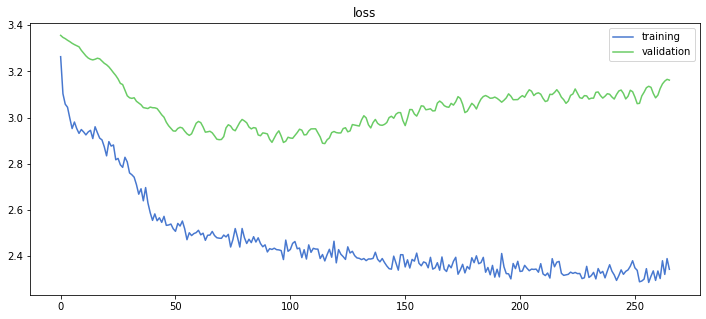

In [98]:
model.load_weights('best_model.h5')
history = pd.read_csv('training.log', sep=',', engine='python')

test_result_df, mae = evaluating(X_test,y_test, model)
print(mae)
plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df.head()

No handles with labels found to put in legend.


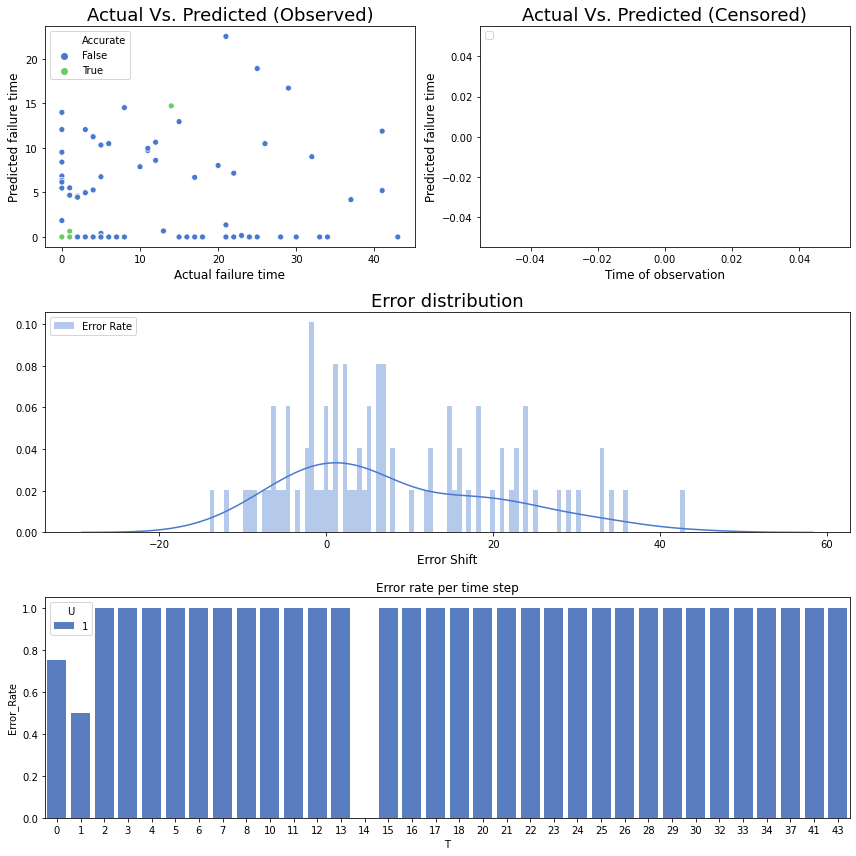

In [99]:
plot_predictions_insights(test_result_df)

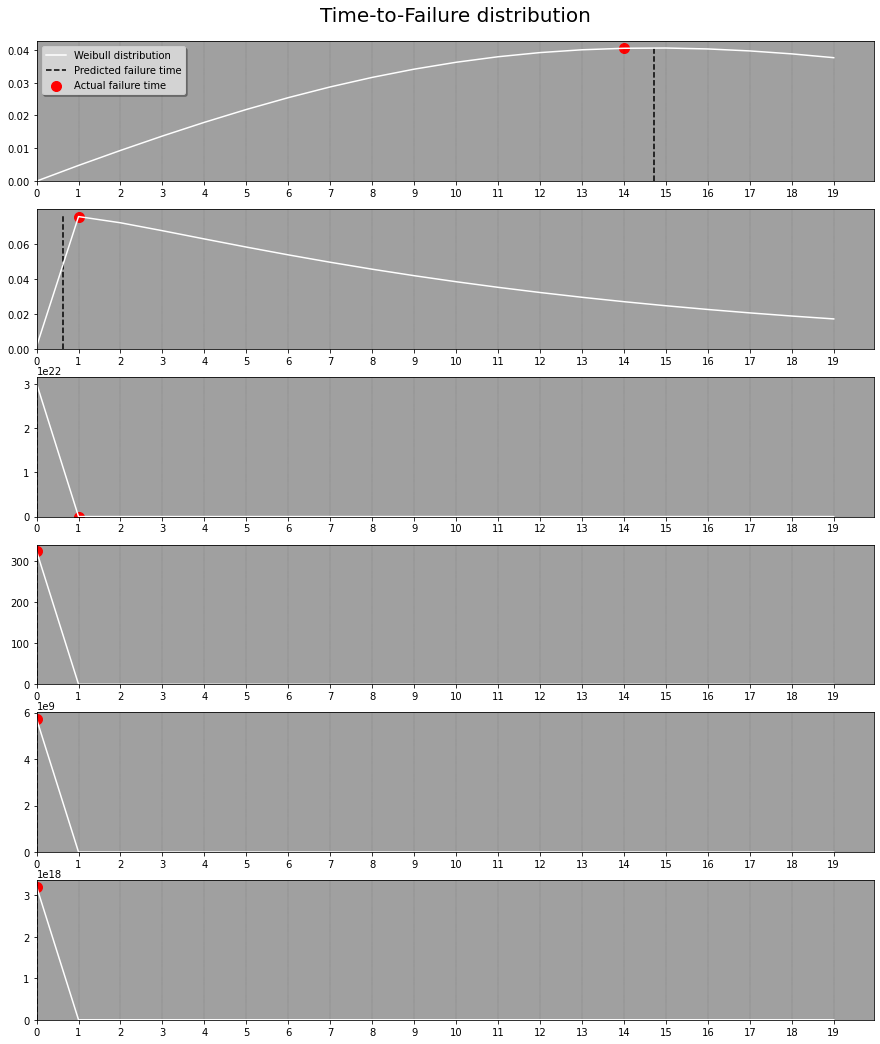

In [100]:
from t2e_utils import *
plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)